In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

import seaborn as sns
from scipy import ndimage

C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('running on:', device)

running on: cuda:0


In [3]:
SOURCE_IMG_SIZE = 48
IMG_SIZE = 48

CLASSES = ['neutral', 'happy', 'surprised', 'sad', 'angry']
NUM_CLASSES = len(CLASSES)

## Pre-processing

In [4]:
df_fer = pd.read_csv('data/fer2013.csv').iloc[:, 1:]
df_ferplus = pd.read_csv('data/ferplus2013.csv').iloc[:, [2, 3, 4, 5, 6]] #  #2:-3
df = df_fer.join(df_ferplus)
# df.head(15)

df['emotion'] = df.iloc[:, 2:].idxmax(axis=1).tolist()
df = df.replace(dict(zip(pd.Series(CLASSES),pd.Series(CLASSES).index)))
# df.head(15)

print('number of images:', df.shape[0])
df = df[(df.iloc[:, 2:-1].max(axis=1) > 5)]
print('after removing images with unknown/unsure classification:', df.shape[0])
# df.head(15)

df = df.iloc[:, [0, 1, -1]]
# df.head(15)

number of images: 35887
after removing images with unknown/unsure classification: 26811


In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

images_np = np.array(df['pixels'])
label_np = np.array(df['emotion'])

images = []
images_raw = []
labels = []

for i in range(df.shape[0]):
    b = bytes(int(p) for p in images_np[i].split())
    img = Image.frombuffer('L', (SOURCE_IMG_SIZE, SOURCE_IMG_SIZE), b)
    transformed_img = transform(img)
    images.append(transformed_img)

    images_raw.append(img)
    labels.append(label_np[i])

## Filtering

In [6]:
kirsch_compass_masks = [
    np.array([[-3,-3,5],[-3,0,5],[-3,-3,5]]),   # north
    np.array([[-3,-3,-3],[-3,0,5],[-3,5,5]]),   # north-east
    np.array([[-3,-3,-3],[-3,0,-3],[5,5,5]]),   # east
    np.array([[-3,-3,-3],[5,0,-3],[5,5,-3]]),   # south-east
    # np.array([[5,-3,-3],[5,0,-3],[5,-3,-3]]),   # south
    # np.array([[5,5,-3],[5,0,-3],[-3,-3,-3]]),   # south-west 
    # np.array([[5,5,5],[-3,0,-3],[-3,-3,-3]]),   # west
    # np.array([[-3,5,5],[-3,0,5],[-3,-3,-3]]),   # north-west
]

robinson_compass_masks = [
    np.array([[-1,-0,1],[-2,0,2],[-1,0,1]]),   # north
    np.array([[0,1,2],[-1,0,1],[-2,-1,0]]),   # north-east
    np.array([[1,2,1],[0,0,0],[-1,-2,-1]]),   # east
    np.array([[2,1,0],[1,0,-1],[0,-1,-2]]),   # south-east
    # np.array([[0,1,2],[-1,0,-1],[-2,-1,0]]),   # south
    # np.array([[0,-1,-2],[1,0,-1],[2,1,0]]),   # south-west 
    # np.array([[2,1,0],[1,0,-1],[0,-1,-2]]),   # west
    # np.array([[-2,-1,0],[-1,0,1],[0,1,2]]),   # north-west
]

sobel_filters = [
    np.array([[1,2,1],[0,0,0],[-1,-2,-1]]),
    np.array([[1,0,-1],[2,0,-2],[1,0,-1]]),
]

roberts_filters = [
    np.array([[1,0],[0,-1]]),
    np.array([[0,-1],[1,0]]),
]

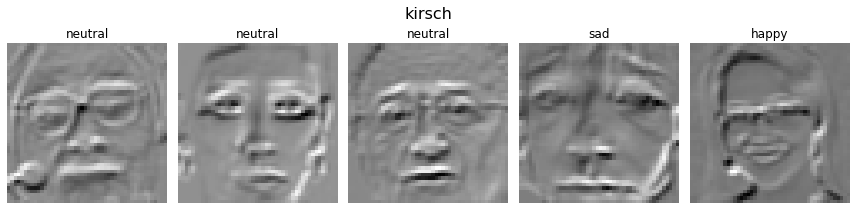

In [7]:
def filter_image(filter):
    imgs_filtered = []

    if filter == 'kirsch':
        filters = kirsch_compass_masks
    elif filter == 'robinson':
        filters = robinson_compass_masks
    elif filter == 'sobel':
        filters = sobel_filters
    elif filter == 'roberts':
        filters = roberts_filters
    else:
        print('ERROR - unrecognized filter')
        return

    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    for i in range(len(images)):
        img = images[i].squeeze(0)

        filtered = np.zeros_like(img)

        for cm in filters:
            k = ndimage.convolve(img, cm, mode='nearest', cval=0.0)
            filtered = np.add(filtered, k)

        # filtered = np.abs(filtered)
        filtered = transform(filtered)
        imgs_filtered.append(filtered)

    n_images = 5
    plt.figure(figsize=(12,3)); plt.suptitle(filter, fontsize=16)
    for j in range(n_images):
        plt.subplot(1, n_images, j+1); plt.axis('off'); plt.title(CLASSES[labels[j]])
        plt.imshow(imgs_filtered[j].permute(1,2,0), cmap='gray')

    plt.tight_layout(); plt.show()

    return imgs_filtered




images_filtered = filter_image('kirsch')
# images_filtered = filter_image('robinson')
# images_filtered = filter_image('sobel')
# images_filtered = filter_image('roberts')

print()

In [8]:
label_counts = [0]*NUM_CLASSES

for i in range(len(labels)):
    label_counts[labels[i]] += 1

print('\033[4m{: <15} {: >10}\033[0m'.format('class', '#images'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >10}'.format(CLASSES[i], label_counts[i]))

class              #images
neutral               9494
happy                 8802
surprised             3461
sad                   2958
angry                 2096


In [9]:
train_split_pct = 0.8
train_len = int(len(labels) * train_split_pct)

train_images = images_filtered[:train_len]
train_labels = labels[:train_len]
test_images = images_filtered[train_len:]
test_labels = labels[train_len:]

print(f'train length: {len(train_labels)} ({len(train_labels)*100/len(labels):.1f}%)')
print(f'test length: {len(test_labels)} ({len(test_labels)*100/len(labels):.1f}%)')

train length: 21448 (80.0%)
test length: 5363 (20.0%)


In [10]:
BATCH_SIZE = 32


class CustomDataset(Dataset):
    
    def __init__(self, images, labels):      
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


train_dataset = CustomDataset(train_images, train_labels)
test_dataset = CustomDataset(test_images, test_labels)


def get_loader(dataset):
    print('get_loader():')

    label_counts = [0]*NUM_CLASSES
    for i in range(len(dataset.labels)):
        label_counts[dataset.labels[i]] += 1

    class_weights = pow(np.array(label_counts) / sum(label_counts), -1)
    print('  class weights:', class_weights.round(3), '\n')

    sample_weights = [0]*len(dataset)
    for idx, (image, label) in enumerate(dataset):
        sample_weights[idx] = class_weights[label]

    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    return DataLoader(dataset, BATCH_SIZE, sampler=sampler, shuffle=False)


train_loader = get_loader(train_dataset)
test_loader = get_loader(test_dataset)

get_loader():
  class weights: [ 2.848  3.015  7.771  8.963 12.991] 

get_loader():
  class weights: [ 2.732  3.175  7.65   9.492 12.052] 



In [11]:
samples_train = [0]*NUM_CLASSES
samples_test = [0]*NUM_CLASSES

for idx, (images_filtered, labels) in enumerate(train_loader):
    for i in range(len(images_filtered)):
        samples_train[labels[i].item()] += 1

for idx, (images_filtered, labels) in enumerate(test_loader):
    for i in range(len(images_filtered)):
        samples_test[labels[i].item()] += 1


print('\033[4m{: <15} {: >15} {: >20}\033[0m'.format('class', '#samples (train)', '#samples (test)'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >15} {: >20}'.format(CLASSES[i], samples_train[i], samples_test[i]))

class           #samples (train)      #samples (test)
neutral                    4350                 1082
happy                      4338                 1058
surprised                  4209                 1115
sad                        4281                 1011
angry                      4270                 1097


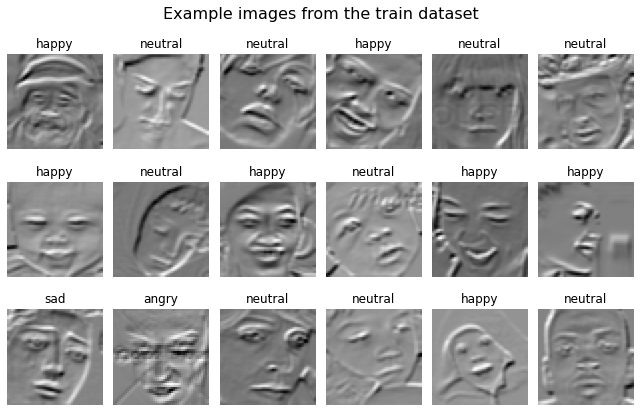

In [12]:
def imshow(dataset, title='', num_images=(3,6), rand=True):

    plt.figure(figsize=(num_images[1]*1.5, num_images[0]*2)); 
    plt.suptitle(title, fontsize=16)

    for i in range(num_images[0]):
        for j in range(num_images[1]):
            
            c = num_images[1]*i+(j+1)

            if not rand:
                idx = c
            else:
                idx = random.randint(0, len(dataset)-1)

            plt.subplot(num_images[0], num_images[1], c); plt.axis('off'); plt.title(CLASSES[dataset[idx][1]])
            plt.imshow(dataset[idx][0].permute(1,2,0), cmap='gray')

    plt.tight_layout(); plt.show()


imshow(train_dataset, 'Example images from the train dataset')

## ResNet

In [13]:
loss_train = []
accuracy_train = []

def train_model(model, criterion, optimizer):
    model.train()
    loss = 0.0
    corrects = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = criterion(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss += loss.item()
        corrects += (pred.argmax(1) == y).type(torch.float).sum().item()


    # epoch_loss = loss / len(train_dataset)
    epoch_accuracy = corrects / len(train_dataset)
    loss_train.append(loss)
    accuracy_train.append(epoch_accuracy)

    print(f'  TRAIN\t loss: {loss:.4f}  |  accuracy: {epoch_accuracy:.4f}')

#####

loss_test = []
accuracy_test = []
y_actual = []
y_pred = []

def test_model(model, criterion):
    model.eval()
    loss = 0.0
    corrects = 0
    
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            pred = model(X)

        y_actual.extend(y.cpu())
        y_pred.extend(pred.argmax(1).cpu())
        
        loss = criterion(pred, y)
        loss += loss.item()
        corrects += (pred.argmax(1) == y).type(torch.float).sum().item()


    # epoch_loss = loss / len(test_dataset)
    epoch_accuracy = corrects / len(test_dataset)
    loss_test.append(loss)
    accuracy_test.append(epoch_accuracy)

    print(f'  TEST\t loss: {loss:.4f}  |  accuracy: {epoch_accuracy:.4f}')

In [14]:
# Based on the Pytorch implementation of ResNet: https://pytorch.org/hub/pytorch_vision_resnet/

def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.ELU(inplace=True)]
  if pool: 
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = conv_block(1, 128)
    self.conv2 = conv_block(128, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
    self.drop1 = nn.Dropout(0.5)
    
    self.conv3 = conv_block(128, 256)
    self.conv4 = conv_block(256, 256, pool=True)
    self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
    self.drop2 = nn.Dropout(0.5)
    
    self.conv5 = conv_block(256, 512)
    self.conv6 = conv_block(512, 512, pool=True)
    self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
    self.drop3 = nn.Dropout(0.5)
    
    self.classifier = nn.Sequential(nn.MaxPool2d(6), nn.Flatten(), nn.Linear(512, NUM_CLASSES))


  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.drop1(out)

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.drop2(out)

    out = self.conv5(out)
    out = self.conv6(out)
    out = self.res3(out) + out
    out = self.drop3(out)

    out = self.classifier(out)
    return out

In [15]:
model_resnet = ResNet()
model_resnet.to(device)

EPOCHS = 20
LEARNING_RATE = 0.005
MOMENTUM = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(model_resnet)
print('Number of parameters: {}'.format(sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)))

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [16]:
for epoch in range(EPOCHS):
    print('Epoch {}/{}'.format(epoch+1, EPOCHS))
    train_model(model_resnet, criterion, optimizer)
    test_model(model_resnet, criterion)
    scheduler.step()

Epoch 1/20


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  TRAIN	 loss: 4.2609  |  accuracy: 0.2451
  TEST	 loss: 2.8990  |  accuracy: 0.3272
Epoch 2/20
  TRAIN	 loss: 2.2935  |  accuracy: 0.3923
  TEST	 loss: 2.3564  |  accuracy: 0.4330
Epoch 3/20
  TRAIN	 loss: 1.1100  |  accuracy: 0.5283
  TEST	 loss: 2.4671  |  accuracy: 0.6138
Epoch 4/20
  TRAIN	 loss: 2.3531  |  accuracy: 0.6300
  TEST	 loss: 1.3526  |  accuracy: 0.6841
Epoch 5/20
  TRAIN	 loss: 0.7207  |  accuracy: 0.6710
  TEST	 loss: 2.2589  |  accuracy: 0.7143
Epoch 6/20
  TRAIN	 loss: 3.3467  |  accuracy: 0.7167
  TEST	 loss: 1.3932  |  accuracy: 0.6981
Epoch 7/20
  TRAIN	 loss: 0.4571  |  accuracy: 0.7536
  TEST	 loss: 1.2252  |  accuracy: 0.7149
Epoch 8/20
  TRAIN	 loss: 1.1565  |  accuracy: 0.8033
  TEST	 loss: 0.8831  |  accuracy: 0.8012
Epoch 9/20
  TRAIN	 loss: 2.2007  |  accuracy: 0.8153
  TEST	 loss: 1.4171  |  accuracy: 0.7884
Epoch 10/20
  TRAIN	 loss: 0.9268  |  accuracy: 0.8243
  TEST	 loss: 0.9003  |  accuracy: 0.8037
Epoch 11/20
  TRAIN	 loss: 0.4077  |  accuracy: 0.

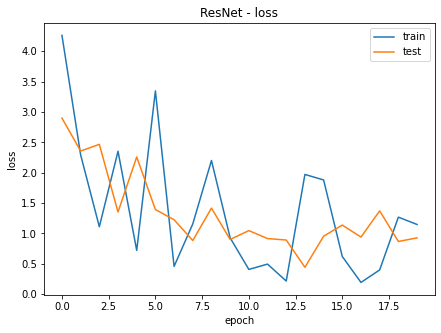

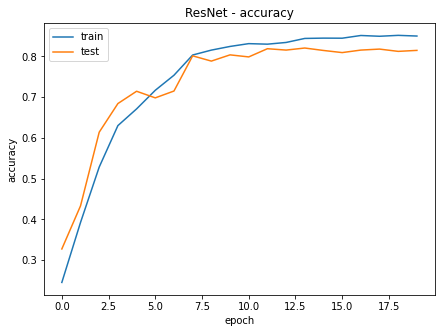

In [17]:
def plot_metric(train, test, metric, title):
    plt.figure(figsize = (7, 5))

    train = torch.tensor(train, device='cpu')
    test = torch.tensor(test, device='cpu')

    with torch.no_grad():
        plt.plot(range(len(train)), train, label = "train")
        plt.plot(range(len(test)), test, label = "test")
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel(metric)
    plt.legend()

    # plt.savefig(f'{title}.png')
    plt.show()


plot_metric(loss_train, loss_test, 'loss', 'ResNet - loss')
plot_metric(accuracy_train, accuracy_test, 'accuracy', 'ResNet - accuracy')

Text(87.0, 0.5, 'Actual')

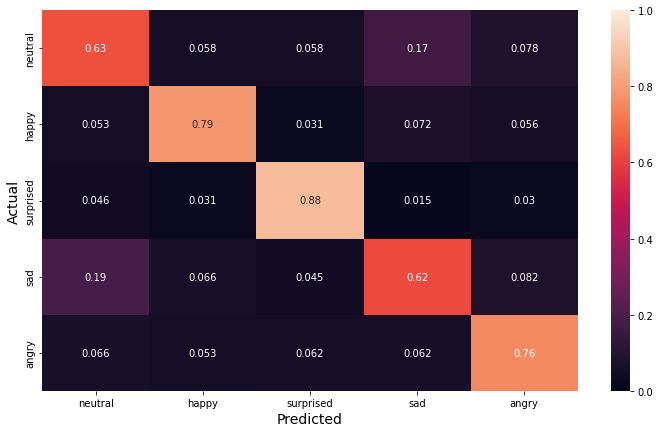

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


counts = np.array([(np.array(y_actual) == i).sum() for i in range(NUM_CLASSES)]).reshape(-1, 1)
cf_matrix = confusion_matrix(y_actual, y_pred)
cf_matrix_norm = cf_matrix / counts

df_cm = pd.DataFrame(cf_matrix_norm, index = CLASSES, columns = CLASSES)
plt.figure(figsize = (12,7))
s = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("rocket", as_cmap=True), vmin=0, vmax=1)
s.set_xlabel('Predicted', fontsize=14)
s.set_ylabel('Actual', fontsize=14)

# plt.savefig('confusion_matrix.png')